In [4]:
import os
import datetime
import wget
import numpy as np
import pandas as pd
import netCDF4 as netcdf
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = 'C:\\Users\\wangc\\anaconda3\\Library\\share\\proj'
from mpl_toolkits.basemap import Basemap

# --------------------------------------------------------
# CalCOFI stations and coordinates
fname = 'CalCOFIStationOrder.csv'
#mixdir = '/Users/a1amador/src/argotest/data/Argo_mixedlayers/'
calcofi_stn_df = pd.read_csv(fname)
calcofi90_stn_df = calcofi_stn_df[calcofi_stn_df['Line ']==90]
lat90 = calcofi90_stn_df['Station Dlatitude '].values
lon90 = calcofi90_stn_df['Dlongitude '].values


In [5]:
# Time conversion functions
now_utc = datetime.datetime.utcnow()

def timeIndexToDatetime(baseTime, times):
    '''
    Function to turn time index into timestamp
    :param baseTime:
    :param times:
    :return:
    '''
    newTimes = []
    for ts in times:
        newTimes.append(baseTime + datetime.timedelta(hours=ts))
    return newTimes

In [8]:
# LOAD HYCOM data
# References: 
# https://ncss.hycom.org/thredds/ncss/grid/GLBy0.08/expt_93.0/dataset.html (hindcast)
# https://ncss.hycom.org/thredds/ncss/grid/GLBy0.08/latest/dataset.html (forecast)

# Inputs: lat,lon,ta,tb
# TODO: variables
dd = 1

LatLim = np.array([29.5,34])
LonLim = np.array([-124.5,-117.3])%180+180
tst = now_utc - pd.Timedelta(days=dd)
ta = tst.strftime("%Y-%m-%dT%H")+'%3A00%3A00Z'
tb = now_utc.strftime("%Y-%m-%dT%H")+'%3A00%3A00Z'

FORECAST = False
if FORECAST:
    # forecast
    modtype = 'latest?'
else:
    # hindcast
    modtype = 'expt_93.0?'


data_url = 'https://ncss.hycom.org/thredds/ncss/GLBy0.08/'+modtype+\
           'var=salinity&var=water_temp&var=water_u&var=water_v&'+\
           'north='+str(LatLim[-1])+'&'+\
           'west='+str(LonLim[0])+'&'+\
           'east='+str(LonLim[-1])+'&'+\
           'south='+str(LatLim[0])+'&'+\
           'disableLLSubset=on&disableProjSubset=on&horizStride=1&'+\
           'time_start='+ta+'&'+\
           'time_end='+tb+'&'+\
           'timeStride=1&'+\
           'vertCoord=0.0&accept=netcdf4' # --> note that the vertical coordinate is set to 0 (surface)

datadir  = ''
filename = 'latest.nc4'
dfnam    = os.path.join(datadir,filename)


# Download data?
dwld_flg=False
# if file exist, remove it directly
if dwld_flg:
    if os.path.exists(dfnam):
        os.remove(dfnam) 
    print('Beginning file download with wget module...')
    wget.download(data_url, out=dfnam)
    print('Downloaded ' + filename)

# Read-in data
netcdf_data = netcdf.Dataset(dfnam)



# hycom_ds.variables['water_u']
print(netcdf_data.variables.keys())

# Extract dimensions
lon = netcdf_data.variables['lon'][:].data
lon0= lon%180-180
lat = netcdf_data.variables['lat'][:].data
# time
times  = netcdf_data.variables['time'][:].data

if FORECAST:
    base_time = datetime.datetime.strptime(netcdf_data.variables['time'].units, "hours since %Y-%m-%d %H:%M:%S.%f %Z")
else:
    base_time = datetime.datetime.strptime(netcdf_data.variables['time'].units, "hours since %Y-%m-%d %H:%M:%S")
# Turn time index into timestamps
times = timeIndexToDatetime(base_time, times)
# pd.to_datetime(base_time)
tt = pd.to_datetime(times)




dict_keys(['salinity', 'time', 'depth', 'lat', 'lon', 'water_temp', 'water_u', 'water_v'])


<ipython-input-28-eaa30677724b>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x,y,var,cmap=plt.cm.jet,shading='flat')


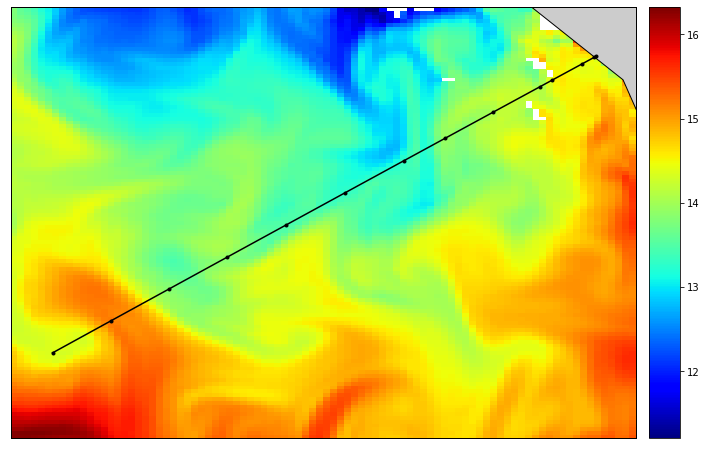

In [28]:
# ------------------------------------------------------------------------------------------
# Plot the field using Basemap.  Start with setting the map

# select time-step
ii =-1
# select variable
var_name = 'water_temp'
# var_name = 'salinity'
var = netcdf_data.variables[var_name][ii,0,:]



# set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
# projection using the limits of the lat/lon data itself:
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon.min(), \
  urcrnrlon=lon.max(),llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
  resolution='c')

# convert the lat/lon values to x/y projections.
x, y = m(*np.meshgrid(lon,lat))
# vehicle
# xv, yv = m(ctdDPdf['longitude'].values[-1]%180+180,ctdDPdf['latitude'].values[-1])
# point queried
# xp, yp = m(lon[iilon],lat[iilat])
# Line 90
xL90, yL90 = m(lon90[:]%180+180,lat90[:])


# plot the field using the fast pcolormesh routine 
m.pcolormesh(x,y,var,cmap=plt.cm.jet,shading='flat')
plt.plot(xL90,yL90,'.-k')
# plt.plot(xv, yv, 'dm', markersize=8)
# plt.text(xv, yv-10000, vnam, fontsize=12);
# plt.plot(xp, yp, 'xk', markersize=8)



# Add a coastline and axis values.
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
# ax.set_xlim(x[0][170],x[0][200])
# ax.set_ylim(y[100][0],y[130][0])

# m.drawparallels(np.arange(30.,60.,10.),labels=[1,0,0,0])
# m.drawmeridians(np.arange(-140.,-90.,10.),labels=[0,0,0,1])

# ax.set_ylim(lon[lonIdx],lon[lonIdx]+1)


# Add a colorbar and title
m.colorbar(location='right')
